This portfolio construction file implements new logic with using a right-merge stock-score dataset. Here, a quartile will be assigned to each month-return row.

In [1]:
import pandas as pd

# Load your real dataset
df = pd.read_csv('../data/processed/full_similarity_with_returns-RIGHT.csv')


df = df.rename(columns={"date": "month"})
df = df.rename(columns={"similarity": "similarity_score"})


df


,permno,cik,tic,month,similarity_score,ret
0,10000.0,NaN,NaN,1986-01-31,NaN,NaN
1,10000.0,NaN,NaN,1986-02-28,NaN,-25.7143
2,10000.0,NaN,NaN,1986-03-31,NaN,36.5385
3,10000.0,NaN,NaN,1986-04-30,NaN,-9.8592
4,10000.0,NaN,NaN,1986-05-30,NaN,-22.2656
...,...,...,...,...,...,...
4054672,93436.0,NaN,NaN,2024-08-30,NaN,-7.7391
4054673,93436.0,NaN,NaN,2024-09-30,NaN,22.1942
4054674,93436.0,1318605.0,tsla,2024-10-31,0.866583,-4.5025
4054675,93436.0,NaN,NaN,2024-11-29,NaN,38.1469


#### Winsorizing:

In [2]:

def winsorize_returns(group):
    lower = group['ret'].quantile(0.01)
    upper = group['ret'].quantile(0.995)

    group['ret'] = group['ret'].clip(lower, upper)
    return group

df = df.groupby('month', group_keys=False).apply(winsorize_returns)

print("Winsorization complete.")


Winsorization complete.


/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_49873/2852208564.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('month', group_keys=False).apply(winsorize_returns)


### Part 1. Ranking stocks based on similarity scores

Assign quintiles to what we have:

In [3]:
def assign_quintiles_with_fallback(df):
    all_quintiles = []

    for month, group in df.groupby("month"):
        # filter out firms with no similarity score
        valid = group.dropna(subset=["similarity_score"]).copy()
        
        # at least 5 firms — use qcut for proper quintiles
        if len(valid) >= 5:
            valid = valid.sort_values("similarity_score", ascending=False).reset_index(drop=True)
            valid["quintile"] = pd.qcut(valid.index, 5, labels=[5,4,3,2,1]).astype(int)
        
        # exactly 2 firms — manually assign quintiles
        elif len(valid) == 2:
            valid = valid.sort_values("similarity_score", ascending=False).reset_index(drop=True)
            valid["quintile"] = [5, 1]

        # 3–4 firms — manually assign top, bottom, and middle values
        elif len(valid) > 2:
            valid = valid.sort_values("similarity_score", ascending=False).reset_index(drop=True)
            ranks = [5] + [3] * (len(valid) - 2) + [1]
            valid["quintile"] = ranks

        # append any valid quintile rows (skip if no valid scores at all)
        all_quintiles.append(valid)

    return pd.concat(all_quintiles)


# Step 2: Apply the quintile assignment to each month group
quintile_df = (
    df.dropna(subset=['similarity_score'])  # keep only rows with similarity score
      .groupby('month', group_keys=False)   # group by month
      .apply(assign_quintiles_with_fallback)               # assign quintiles within each month
)


quintile_df

/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_49873/72292322.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(assign_quintiles_with_fallback)               # assign quintiles within each month


,permno,cik,tic,month,similarity_score,ret,quintile
1116721,22592.0,66740.0,mmm,1993-11-30,0.990806,5.8602,NaN
0,19880.0,15615.0,mtz,1994-01-31,0.936273,37.2340,5.0
1,51086.0,107687.0,wgo,1994-01-31,0.757011,20.2532,1.0
0,10397.0,793074.0,wern,1994-02-28,1.000000,-1.6949,5.0
1,19880.0,15615.0,mtz,1994-02-28,0.979516,-5.4264,5.0
...,...,...,...,...,...,...,...
0,92121.0,1393612.0,dfs,2024-12-31,0.998017,-5.0430,5.0
1,92121.0,1393612.0,dfs,2024-12-31,0.996312,-5.0430,4.0
2,87394.0,1058811.0,immr,2024-12-31,0.985401,-2.3490,3.0
3,92121.0,1393612.0,dfs,2024-12-31,0.977140,-5.0430,2.0


Merge assigned quintiles back into the full dataset (which includes months with missing scores)

In [4]:
df = df.merge(quintile_df, on=['permno', 'month'], how='left')

df

,permno,cik_x,tic_x,month,similarity_score_x,ret_x,cik_y,tic_y,similarity_score_y,ret_y,quintile
0,10000.0,NaN,NaN,1986-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000.0,NaN,NaN,1986-02-28,NaN,-25.7143,NaN,NaN,NaN,NaN,NaN
2,10000.0,NaN,NaN,1986-03-31,NaN,36.5385,NaN,NaN,NaN,NaN,NaN
3,10000.0,NaN,NaN,1986-04-30,NaN,-9.8592,NaN,NaN,NaN,NaN,NaN
4,10000.0,NaN,NaN,1986-05-30,NaN,-22.2656,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4064213,93436.0,NaN,NaN,2024-08-30,NaN,-7.7391,NaN,NaN,NaN,NaN,NaN
4064214,93436.0,NaN,NaN,2024-09-30,NaN,22.1942,NaN,NaN,NaN,NaN,NaN
4064215,93436.0,1318605.0,tsla,2024-10-31,0.866583,-4.5025,1318605.0,tsla,0.866583,-4.5025,1.0
4064216,93436.0,NaN,NaN,2024-11-29,NaN,38.1469,NaN,NaN,NaN,NaN,NaN


Clean it up:

In [5]:

# Keep original df columns
columns_to_keep = [col for col in df.columns if col.endswith('_x')]
df = df[columns_to_keep + ['permno', 'month', 'quintile']]  # Add merge keys and new quintile

# Rename columns
df = df.rename(columns=lambda x: x.replace('_x', ''))  # Remove _x suffix

Forward-filling the quintile ranks to the rows where we assume that traders trade on the old report's similarity score until a new report comes out and a new score is computed.

In [6]:
df = df.sort_values(['permno', 'month'])
df['quintile'] = df.groupby('permno')['quintile'].ffill()

df

,cik,tic,similarity_score,ret,permno,month,quintile
0,NaN,NaN,NaN,NaN,10000.0,1986-01-31,NaN
1,NaN,NaN,NaN,-25.7143,10000.0,1986-02-28,NaN
2,NaN,NaN,NaN,36.5385,10000.0,1986-03-31,NaN
3,NaN,NaN,NaN,-9.8592,10000.0,1986-04-30,NaN
4,NaN,NaN,NaN,-22.2656,10000.0,1986-05-30,NaN
...,...,...,...,...,...,...,...
4064213,NaN,NaN,NaN,-7.7391,93436.0,2024-08-30,2.0
4064214,NaN,NaN,NaN,22.1942,93436.0,2024-09-30,2.0
4064215,1318605.0,tsla,0.866583,-4.5025,93436.0,2024-10-31,1.0
4064216,NaN,NaN,NaN,38.1469,93436.0,2024-11-29,1.0


Dropping rows without a quintile assigned: there were never any reports for those months.

In [7]:
df = df.dropna(subset=['quintile'])

df

,cik,tic,similarity_score,ret,permno,month,quintile
4711,785956.0,jjsf,0.718622,4.1237,10026.0,1995-06-30,1.0
4712,NaN,NaN,NaN,-6.9307,10026.0,1995-07-31,1.0
4713,785956.0,jjsf,0.722793,4.2553,10026.0,1995-08-31,1.0
4714,NaN,NaN,NaN,-4.0816,10026.0,1995-09-29,1.0
4715,NaN,NaN,NaN,-5.3192,10026.0,1995-10-31,1.0
...,...,...,...,...,...,...,...
4064213,NaN,NaN,NaN,-7.7391,93436.0,2024-08-30,2.0
4064214,NaN,NaN,NaN,22.1942,93436.0,2024-09-30,2.0
4064215,1318605.0,tsla,0.866583,-4.5025,93436.0,2024-10-31,1.0
4064216,NaN,NaN,NaN,38.1469,93436.0,2024-11-29,1.0


### Part 2: Constructing Portfolios and Trading on them.

Compute monthly long-short portfolio returns

In [8]:
df = df.dropna(subset=['ret'])


portfolio_rets = []
for month, group in df.groupby('month'):
    long_ret = group.loc[group['quintile'] == 5, 'ret'].mean()
    short_ret = group.loc[group['quintile'] == 1, 'ret'].mean()
    long_short = long_ret - short_ret
    portfolio_rets.append({'month': month, 'portfolio_return': long_short})

portfolio_df = pd.DataFrame(portfolio_rets)
portfolio_df['month'] = pd.to_datetime(portfolio_df['month'])
portfolio_df = portfolio_df.sort_values('month')

Calculate cumulative return (growth of $1, if ret is percent, convert to decimal first)

In [9]:
portfolio_df['portfolio_return_decimal'] = portfolio_df['portfolio_return'] / 100
portfolio_df['cum_portfolio'] = (1 + portfolio_df['portfolio_return_decimal']).cumprod()

portfolio_df

,month,portfolio_return,portfolio_return_decimal,cum_portfolio
0,1994-01-31,16.980800,0.169808,1.169808
1,1994-02-28,-32.322887,-0.323229,0.791692
2,1994-03-31,-10.924324,-0.109243,0.705205
3,1994-04-29,-2.133119,-0.021331,0.690162
4,1994-05-31,-0.271882,-0.002719,0.688286
...,...,...,...,...
367,2024-08-30,-0.940091,-0.009401,0.524043
368,2024-09-30,-0.034985,-0.000350,0.523860
369,2024-10-31,0.124382,0.001244,0.524511
370,2024-11-29,0.611263,0.006113,0.527717


Plot monthly portfolio returns:

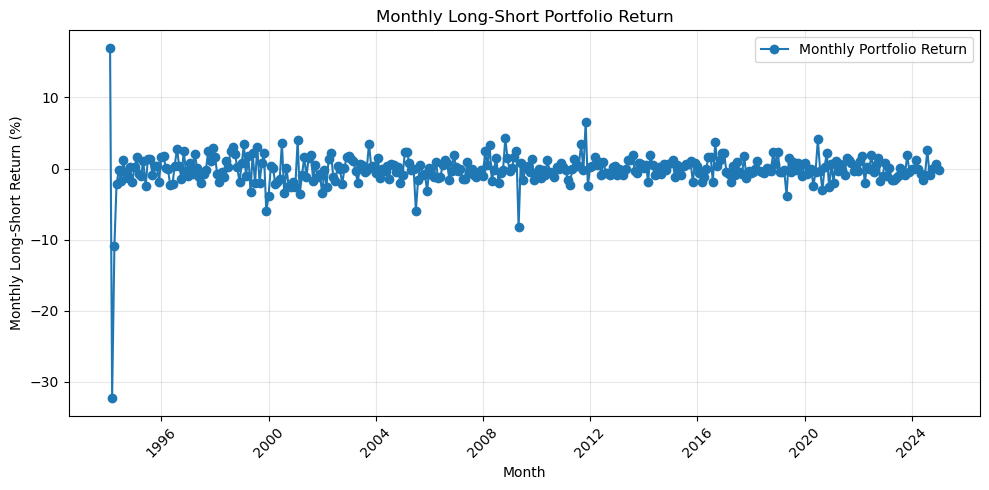

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['portfolio_return'], marker='o', label='Monthly Portfolio Return')
plt.xlabel('Month')
plt.ylabel('Monthly Long-Short Return (%)')
plt.title('Monthly Long-Short Portfolio Return')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [11]:
print(portfolio_df['portfolio_return_decimal'].mean())

-0.0013626511662945555


The monthly returns are extremely volatile.
- trading only 1 long 1 short stock can skew this a lot
- we don't have information on market cap to weigh it


-> might have to only keep portfolios in months with a lot of stocks


Plot cumulative returns

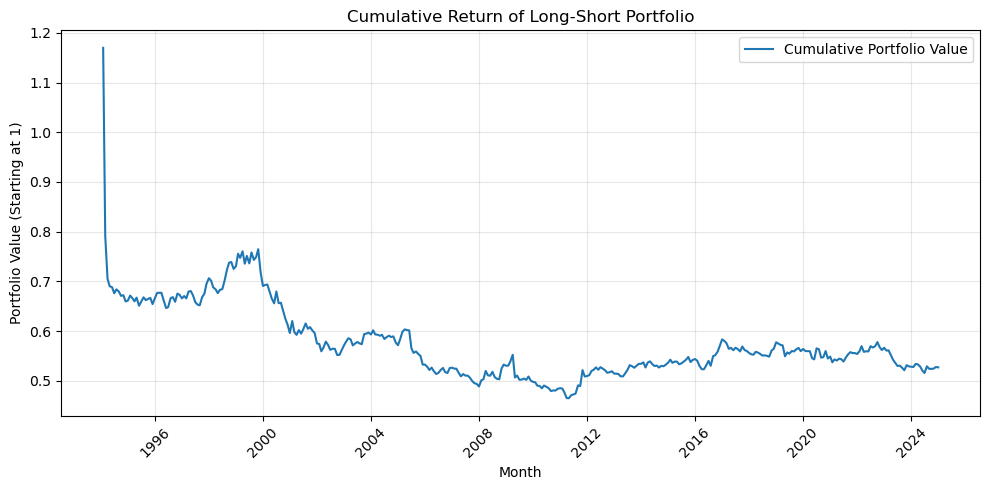

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['cum_portfolio'], label='Cumulative Portfolio Value')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return of Long-Short Portfolio')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# For each month, count how many stocks we have
month_sizes = df['month'].value_counts().sort_index()
print(month_sizes)


month
1994-01-31       4
1994-02-28      14
1994-03-31      91
1994-04-29      24
1994-05-31     370
              ... 
2024-08-30    1831
2024-09-30    1842
2024-10-31    1856
2024-11-29    1810
2024-12-31    1818
Name: count, Length: 372, dtype: int64


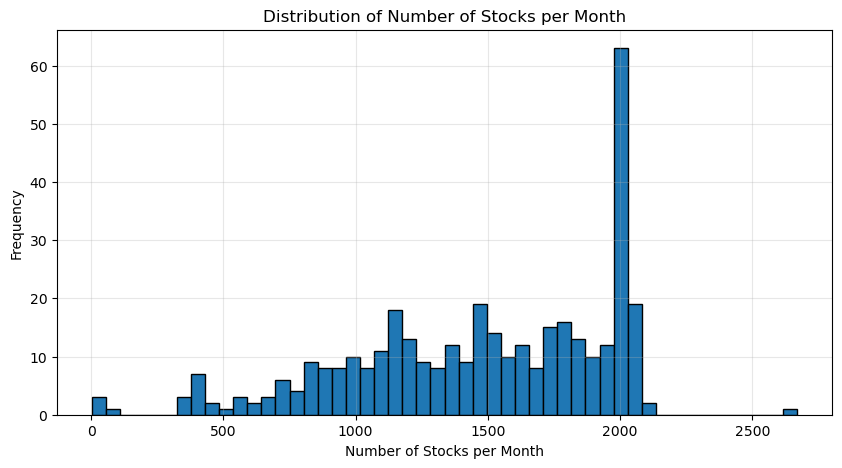

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(month_sizes, bins=50, edgecolor='k')
plt.xlabel('Number of Stocks per Month')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Stocks per Month')
plt.grid(alpha=0.3)
plt.show()


Filter portfolio returns based on month count:

/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_49873/1099699524.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  portfolio_df_filtered = portfolio_df[portfolio_df['month'].isin(valid_months)].copy()


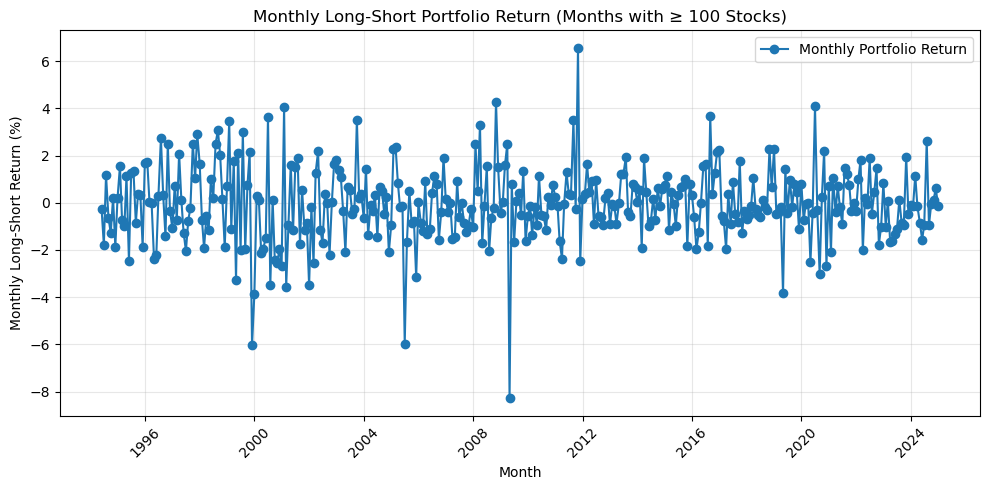

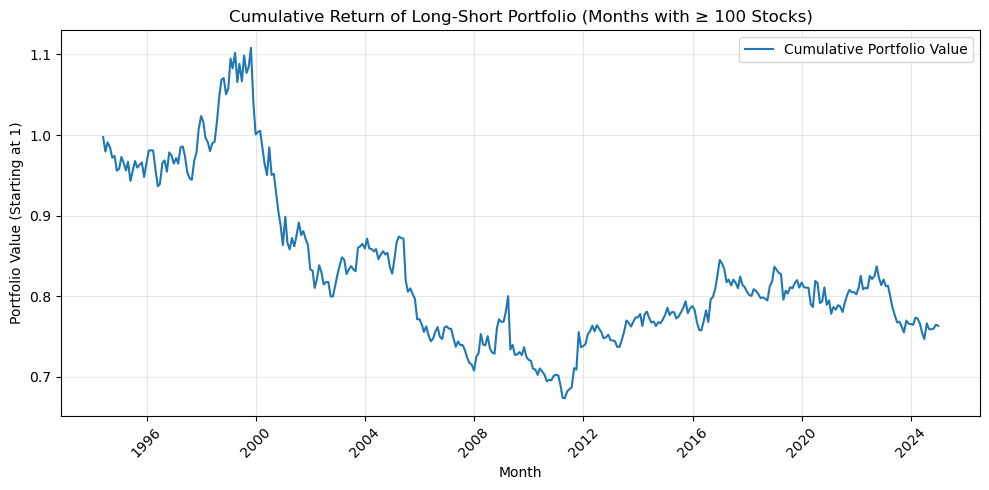

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Count number of firms per month from full df
month_sizes = df['month'].value_counts().sort_index()

# Step 2: Filter portfolio_df to only include months with >= 100 stocks
valid_months = month_sizes[month_sizes >= 100].index
portfolio_df_filtered = portfolio_df[portfolio_df['month'].isin(valid_months)].copy()

# Step 3: Plot monthly returns
plt.figure(figsize=(10,5))
plt.plot(portfolio_df_filtered['month'], portfolio_df_filtered['portfolio_return'], marker='o', label='Monthly Portfolio Return')
plt.xlabel('Month')
plt.ylabel('Monthly Long-Short Return (%)')
plt.title('Monthly Long-Short Portfolio Return (Months with ≥ 100 Stocks)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Recalculate and plot cumulative return
portfolio_df_filtered['portfolio_return_decimal'] = portfolio_df_filtered['portfolio_return'] / 100
portfolio_df_filtered['cum_portfolio'] = (1 + portfolio_df_filtered['portfolio_return_decimal']).cumprod()

plt.figure(figsize=(10,5))
plt.plot(portfolio_df_filtered['month'], portfolio_df_filtered['cum_portfolio'], label='Cumulative Portfolio Value')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return of Long-Short Portfolio (Months with ≥ 100 Stocks)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 5: Save to CSV
portfolio_df_filtered.to_csv("../data/processed/filtered_portfolio_returns-PROP.csv", index=False)


In [16]:
print(portfolio_df_filtered['portfolio_return_decimal'].mean())

-0.0006057362452640733


Logic
1.
a. Sort all firms by their similarity_score for that month (the higher the score, the more “similar” their filing is to the previous one).
b. Assign quintiles (divide into 5 groups) based on the similarity_score within that month:
Top 20% (5th quintile): Firms with the highest similarity
Bottom 20% (1st quintile): Firms with the lowest similarity
2.
Long leg: Go long (buy) all stocks in the top quintile (highest similarity).
Short leg: Go short (sell) all stocks in the bottom quintile (lowest similarity).

Returns are equally weighted within each leg (i.e., average the returns for the long group and the short group).
3.
Long-short return = Mean(return of long leg) - Mean(return of short leg)

Key
If the long-short return is consistently positive:It means firms with high similarity (i.e., "lazy" prices) tend to outperform those with low similarity, after controlling for general market movements.
